<a href="https://colab.research.google.com/github/jjavy/MCDAA/blob/main/Tarea_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
import itertools
import math

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Maestria/AA/Coffe_sales_cleaned.csv')

In [3]:
# NOTA: cash_type siempre es 1, así que fue ignorado
cols = ['hour_of_day', 'coffee_ordered', 'Time_of_Day', 'Weekdaysort', 'Monthsort']

# Scale cols
scaler = StandardScaler()
X = scaler.fit_transform(df[cols])
X_pre = pd.DataFrame(X, columns=cols)
y = df['money'].values # No se escala "money" para evitar ruido en la predicción más adelante

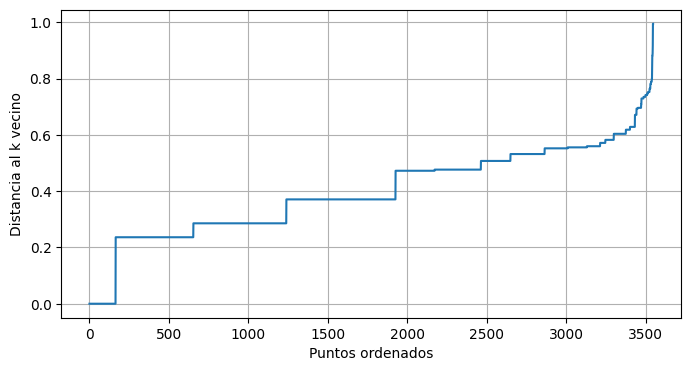

Clusters found: 3, noise fraction: 0.006


In [4]:
from sklearn.neighbors import NearestNeighbors

# Estimar eps con k-distance (k = minPts)
minPts = 5
nbrs = NearestNeighbors(n_neighbors=minPts).fit(X_pre)
distances, indices = nbrs.kneighbors(X_pre)
kdist = np.sort(distances[:, -1])
# plot k-distance
plt.figure(figsize=(8,4))
plt.plot(kdist)
plt.ylabel('Distancia al k vecino')
plt.xlabel('Puntos ordenados')
plt.grid(True)
plt.show()

eps = 0.63
db = DBSCAN(eps=eps, min_samples=minPts, metric='euclidean', n_jobs=-1).fit(X_pre)
labels = db.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
noise_fraction = np.mean(labels == -1)

print(f"Clusters found: {n_clusters}, noise fraction: {noise_fraction:.3f}")

In [5]:
# Métricas de calidad de los conglomerados (Solo si >1 conglomerado y no son todos -1)
if n_clusters > 1:
    sil = silhouette_score(X_pre, labels)
    db_index = davies_bouldin_score(X_pre, labels)
    ch = calinski_harabasz_score(X_pre, labels)
    print(f"Silhouette: {sil:.3f}, Davies-Bouldin: {db_index:.3f}, Calinski-Harabasz: {ch:.3f}")
else:
    print("No enough clusters for silhouette/davies/calinski.")

Silhouette: 0.177, Davies-Bouldin: 2.358, Calinski-Harabasz: 734.722


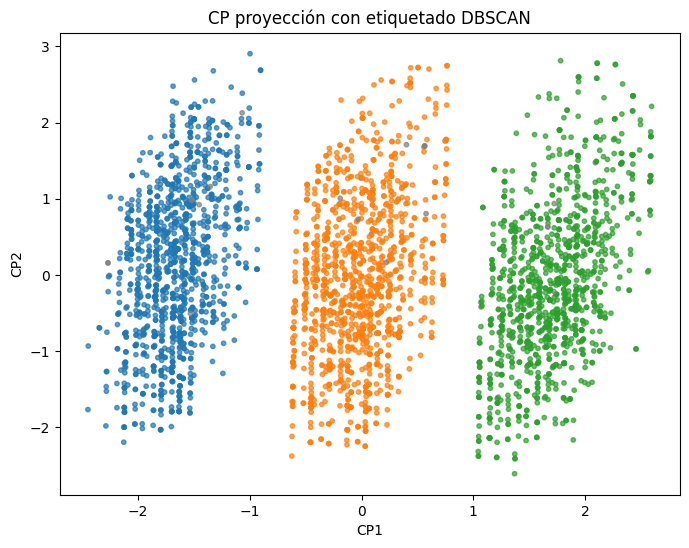

In [6]:
# PCA visualización
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_pre)
plt.figure(figsize=(8,6))
palette = sns.color_palette('tab10', n_colors=max(2, n_clusters))
# map label -1 to gray
colors = ['#808080' if lab==-1 else palette[lab % 10] for lab in labels]
plt.scatter(X_pca[:,0], X_pca[:,1], c=colors, s=10, alpha=0.7)
plt.title('CP proyección con etiquetado DBSCAN')
plt.xlabel('CP1'); plt.ylabel('CP2')
plt.show()

In [7]:
# Bosques aleatorios
X_train, X_test, y_train, y_test = train_test_split(X_pre, y, test_size=0.25, random_state=42)

rf = RandomForestRegressor(n_estimators=200, max_depth=None, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

mae_val = mean_absolute_error(y_test, y_pred)
rmse_val = np.sqrt(mean_squared_error(y_test, y_pred))
denom = np.clip(np.abs(y_test), eps, None)
mape_val = np.mean(np.abs((y_test - y_pred) / denom)) * 100
r2_val = r2_score(y_test, y_pred)

print(f"Resultados: MAE={mae_val:.4f}, RMSE={rmse_val:.4f}, MAPE={mape_val:.2f}%, R2={r2_val:.3f}")

Resultados: MAE=0.2901, RMSE=0.7704, MAPE=0.94%, R2=0.975


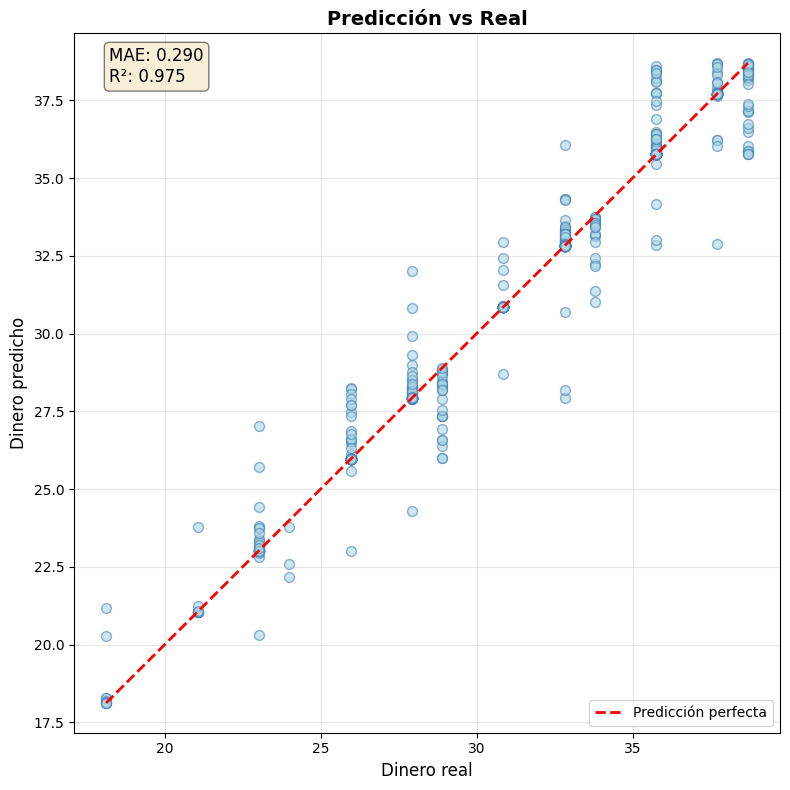

In [36]:
# Plot predicción vs real
plt.figure(figsize=(8, 8))

# Scatter con mejor estilo
plt.scatter(y_test, y_pred, alpha=0.6, s=50, edgecolors='steelblue',
            facecolors='lightblue', linewidth=1)

# Línea de predicción perfecta
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'r--', linewidth=2, label='Predicción perfecta')

# Añadir métricas al gráfico
plt.text(0.05, 0.98, f'MAE: {mae_val:.3f}\nR²: {r2_val:.3f}',
         transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(boxstyle='round',
         facecolor='wheat', alpha=0.5))

plt.xlabel('Dinero real', fontsize=12)
plt.ylabel('Dinero predicho', fontsize=12)
plt.title('Predicción vs Real', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')  # Mantiene escala 1:1
plt.tight_layout()
plt.show()

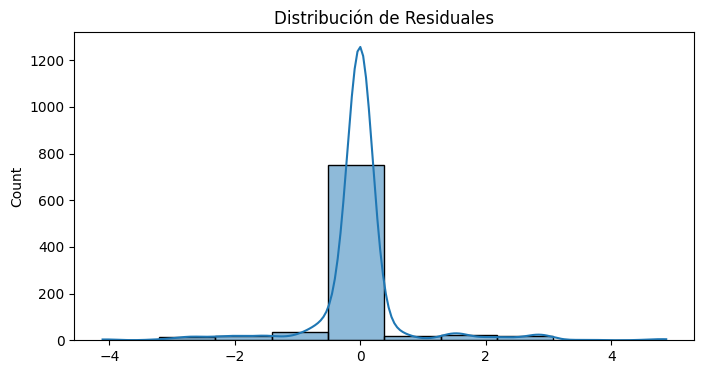

In [15]:
resid = y_test - y_pred
plt.figure(figsize=(8,4))
sns.histplot(resid, kde=True, bins=10)
plt.title('Distribución de Residuales')
plt.show()

In [37]:
# Comparar las metricas

models = {
    'RF_100': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'RF_200': RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1),
    'RF_300': RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1),
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_p = model.predict(X_test)
    denom = np.clip(np.abs(y_test), eps, None)
    results.append({
        'model': name,
        'MAE': mean_absolute_error(y_test, y_p),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_p)),
        'MAPE': np.mean(np.abs((y_test - y_p) / denom)) * 100,
        'R2': r2_score(y_test, y_p)
    })
res_df = pd.DataFrame(results).set_index('model')
res_df


,MAE,RMSE,MAPE,R2
model,,,,
RF_100,0.287203,0.755603,0.927665,0.975692
RF_200,0.290161,0.761695,0.938703,0.975299
RF_300,0.290512,0.761293,0.939748,0.975325


In [25]:
# Diseño de Experimento (DOE) — factorial completo pequeño
# Factores propuestos:
# B: DBSCAN eps: [0.5, 0.55, 0.63, 0.7]  (4 niveles)
# C: MinPts: [3,5,10] (3 niveles)
# D: Número de estimadores: [100, 200, 300]  (3 niveles)
# E: Usar las etiquetas del conglomerado como caracteristica adicional? [False, True]

f_factor = {
    'eps': [0.5, 0.55, 0.63, 0.7],
    'minPts': [3,5,10],
    'n_estimators': [100, 200, 300],
    'use_cluster_label': [False, True]
}

keys, values = zip(*f_factor.items())
exp_runs = [dict(zip(keys, v)) for v in itertools.product(*values)]
len(exp_runs)

72

In [26]:
# Ejecutar DOE
exp_results = []
print(f"Iniciando {len(exp_runs)} iteraciones")
for i, run in enumerate(exp_runs):
    X_tmp = df[cols].copy()
    X_tmp = pd.get_dummies(X_tmp, drop_first=True)

    # Estandarizar caracteristicas para DBSCAN
    scaler = StandardScaler()
    X_s = scaler.fit_transform(X_tmp)

    db = DBSCAN(eps=run['eps'], min_samples=run['minPts']).fit(X_s)
    labels = db.labels_
    # Optionalmente usar las etiquetas del conglomerado como caracteristica
    if run['use_cluster_label']:
        X_tmp['cluster_label'] = labels
        X_tmp = pd.get_dummies(X_tmp, columns=['cluster_label'], prefix='cl', dummy_na=False)

    # Alinear objetivo
    X_train, X_test, y_train, y_test = train_test_split(X_tmp, df['money'].values, test_size=0.25, random_state=42)

    model = RandomForestRegressor(n_estimators=run['n_estimators'], random_state=42, n_jobs=-1)

    model.fit(X_train, y_train)
    y_p = model.predict(X_test)
    mae_v = mean_absolute_error(y_test, y_p)
    rmse_v = np.sqrt(mean_squared_error(y_test, y_p))
    denom = np.clip(np.abs(y_test), run['eps'], None)
    mape_v = np.mean(np.abs((y_test - y_p) / denom)) * 100

    exp_results.append({
        **run,
        'MAE': mae_v,
        'RMSE': rmse_v,
        'MAPE': mape_v,
        'R2': r2_score(y_test, y_p),
        'n_clusters': len(set(labels)) - (1 if -1 in labels else 0),
        'noise_frac': np.mean(labels == -1)
    })

    # Indicador de progreso
    if (i+1) % 10 == 0:
        print(f"Completadas {i+1}/{len(exp_runs)} iteraciones")

exp_df = pd.DataFrame(exp_results)
exp_df

Iniciando 72 iteraciones
Completadas 10/72 iteraciones
Completadas 20/72 iteraciones
Completadas 30/72 iteraciones
Completadas 40/72 iteraciones
Completadas 50/72 iteraciones
Completadas 60/72 iteraciones
Completadas 70/72 iteraciones


,eps,minPts,n_estimators,use_cluster_label,MAE,RMSE,MAPE,R2,n_clusters,noise_frac
0,0.5,3,100,False,0.289917,0.765246,0.940303,0.975068,109,0.074711
1,0.5,3,100,True,0.277198,0.747722,0.897759,0.976197,109,0.074711
2,0.5,3,200,False,0.290364,0.766029,0.941348,0.975017,109,0.074711
3,0.5,3,200,True,0.276892,0.747358,0.895645,0.976220,109,0.074711
4,0.5,3,300,False,0.291576,0.766616,0.945482,0.974979,109,0.074711
...,...,...,...,...,...,...,...,...,...,...
67,0.7,10,100,True,0.287203,0.755603,0.927665,0.975692,5,0.019735
68,0.7,10,200,False,0.290364,0.766029,0.941348,0.975017,5,0.019735
69,0.7,10,200,True,0.290161,0.761695,0.938703,0.975299,5,0.019735
70,0.7,10,300,False,0.291576,0.766616,0.945482,0.974979,5,0.019735


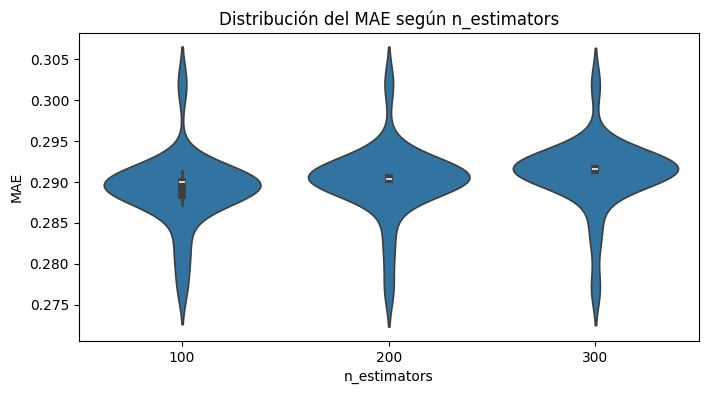

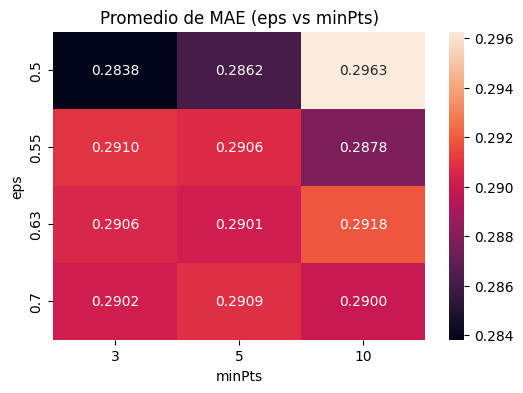

<Figure size 1200x500 with 0 Axes>

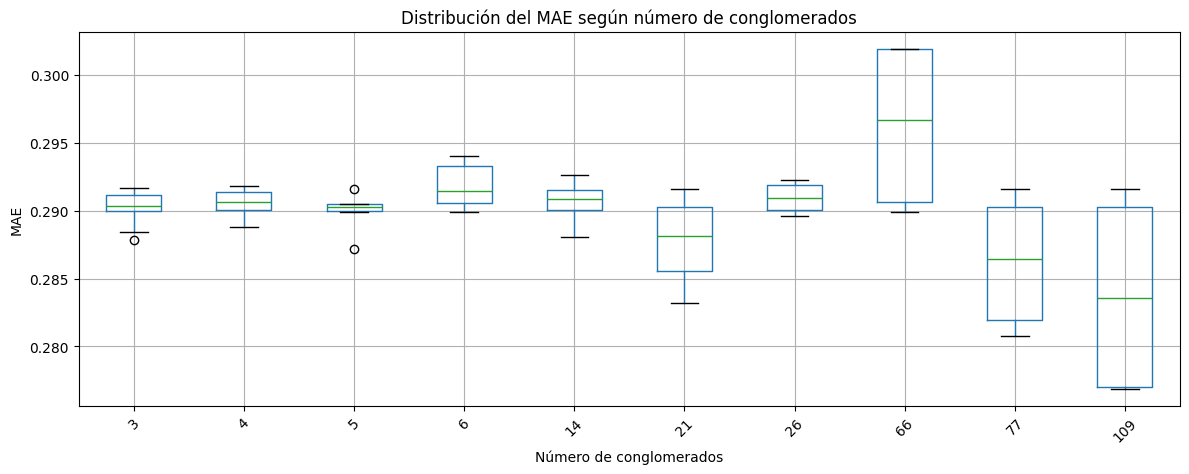

In [38]:
# Visualizaciones DOE results
plt.figure(figsize=(8,4))
sns.violinplot(x='n_estimators', y='MAE', data=exp_df)
plt.title('Distribución del MAE según n_estimators')
plt.show()

# Heatmap: Promedio del MAE por eps vs minPts
pivot = exp_df.groupby(['eps','minPts'])['MAE'].mean().unstack()
plt.figure(figsize=(6,4))
sns.heatmap(pivot, annot=True, fmt=".4f")
plt.title('Promedio de MAE (eps vs minPts)')
plt.show()

plt.figure(figsize=(12, 5))
exp_df_sorted = exp_df.sort_values('n_clusters')
exp_df_sorted.boxplot(column='MAE', by='n_clusters', figsize=(12, 5))
plt.xlabel('Número de conglomerados')
plt.ylabel('MAE')
plt.title('Distribución del MAE según número de conglomerados')
plt.suptitle('')  # Elimina el título automático
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()